# Pipeline of the anomaly detection on the SKAB using Hotelling's $T^2$ statistic

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [1]:
# libraries importing
import sys
import warnings

import pandas as pd

sys.path.append("..")
from core.t2 import T2
from core.metrics import chp_score
from core.utils import load_preprocess_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [2]:
Xy_traintest_list = load_preprocess_skab()

## Method

### Method initialization

In [3]:
# classifier initializing
model = T2(scaling=True, using_pca=False)

### Method fitting and applying

In [4]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    # classifier fitting
    model.fit(X_train)

    # results predicting
    model.predict(
        X_test,
        window_size=5,
        plot_fig=False,
    )
    prediction = pd.Series(
        (model.t2["T2"].values > (2 * model.t2_ucl)).astype(int),
        index=X_test.index,
    ).fillna(0)
    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["changepoint"])

### Results visualization

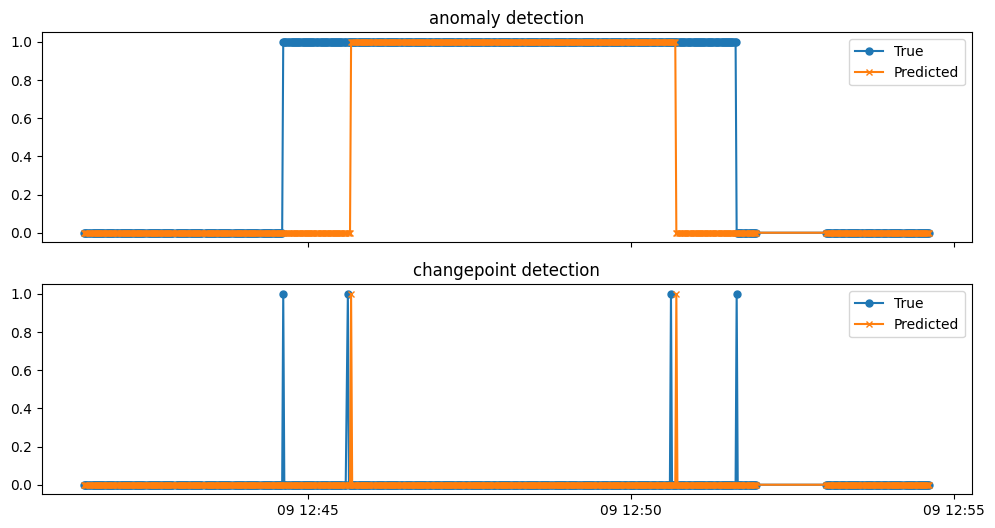

In [5]:
# [donotremove]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

In [6]:
import pickle

pickle.dump(
    predicted_outlier, open(f"results-{model.__class__.__name__}.pkl", "wb")
)

### Binary classification (outlier detection) metrics

In [7]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 19.21 %
Missing Alarm Rate 42.6 %
F1 metric 0.66


### Changepoint detection metrics

In [8]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    window_width="60s",
    anomaly_window_destination="righter",
)

Amount of true anomalies 127
A number of missed CPs = 84
A number of FPs = 203
Average time 0 days 00:00:18.232558139


In [9]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="60s",
    anomaly_window_destination="righter",
)

Standard  -  19.54
LowFP  -  10.2
LowFN  -  24.31
